# Benchmarking the Neural Network Library

## Experiment Overview

This notebook benchmarks a custom neural network library by training a feedforward neural network on a synthetic regression task. The experiment measures training and inference performance, as well as error metrics, to evaluate the efficiency and accuracy of the implementation.

### Benchmarking Statistics

The following statistics are measured and visualized:
- **Training RMS Error per Epoch:** Tracks the root mean square error on the training set after each epoch.
- **Training Time per Epoch:** Measures the time taken to complete each training epoch.
- **Test RMS Error:** Evaluates the model's generalization by computing RMS error on a held-out test set.
- **Feedforward Throughput:** Calculates the number of feedforward computations per second during inference.
- **Total Trainable Parameters:** Logs the total number of parameters in the network, providing insight into model complexity.

## Code Implementation

### Importing the Neural Network Library

First, import the necessary classes from the `neural_network` library, as well as supporting libraries for data handling and visualization.

In [1]:
import logging
import time

import matplotlib.pyplot as plt
import numpy as np

from neural_network.layer import HiddenLayer, InputLayer, OutputLayer
from neural_network.math.activation_functions import LinearActivation, SigmoidActivation
from neural_network.neural_network import NeuralNetwork

logging.basicConfig(format="%(asctime)s %(message)s", datefmt="[%d-%m-%Y|%H:%M:%S]", level=logging.INFO)
logger = logging.getLogger(__name__)
rng = np.random.default_rng()


In [2]:
# Neural network parameters
NUM_INPUTS = 8
HIDDEN_LAYER_SIZES = [32, 16, 8]
NUM_OUTPUTS = 2
INPUT_ACTIVATION = LinearActivation
HIDDEN_ACTIVATION = SigmoidActivation
OUTPUT_ACTIVATION = LinearActivation
WEIGHTS_RANGE = (-1, 1)
BIAS_RANGE = (-0.1, 0.1)
LR = 0.01

# Dataset parameters
NUM_EPOCHS = 100
DATASET_SIZE = 2000
TRAIN_SIZE_RATIO = 0.8
TEST_INDEX = int(DATASET_SIZE * TRAIN_SIZE_RATIO)

In [ ]:
def count_trainable_parameters(layers: list[int]) -> int:
    """Calculate the total number of trainable parameters in a fully connected neural network.

    :param list[int] layers:
        List containing the number of neurons in each layer (including input layer).
    :return int:
        Total number of trainable parameters.
    """
    total_params = 0

    for i in range(1, len(layers)):  # Start from the first hidden layer
        weights = layers[i] * layers[i - 1]  # Weight parameters
        biases = layers[i]  # Bias parameters
        total_params += weights + biases

    return total_params

logger.info("Creating neural network with the following parameters:")
logger.info("Inputs: %s", NUM_INPUTS)
logger.info("Hidden layers: %s", HIDDEN_LAYER_SIZES)
logger.info("Outputs: %s", NUM_OUTPUTS)
logger.info("Input activation: %s", INPUT_ACTIVATION.__name__)
logger.info("Hidden activation: %s", HIDDEN_ACTIVATION.__name__)
logger.info("Output activation: %s", OUTPUT_ACTIVATION.__name__)
logger.info("Weights range: %s", WEIGHTS_RANGE)
logger.info("Bias range: %s", BIAS_RANGE)
logger.info("Learning rate: %s", LR)
logger.info("Number of trainable parameters: %s", count_trainable_parameters(
    [NUM_INPUTS, *HIDDEN_LAYER_SIZES, NUM_OUTPUTS]))

input_layer = InputLayer(size=NUM_INPUTS, activation=INPUT_ACTIVATION)
hidden_layers = [
    HiddenLayer(size=size, activation=HIDDEN_ACTIVATION, weights_range=WEIGHTS_RANGE, bias_range=BIAS_RANGE)
    for size in HIDDEN_LAYER_SIZES
]
output_layer = OutputLayer(
    size=NUM_OUTPUTS, activation=OUTPUT_ACTIVATION, weights_range=WEIGHTS_RANGE, bias_range=BIAS_RANGE
)

nn = NeuralNetwork.from_layers(layers=[input_layer, *hidden_layers, output_layer], lr=LR)

[06-06-2025|00:28:48] Creating neural network with the following parameters:
[06-06-2025|00:28:48] Inputs: 8
[06-06-2025|00:28:48] Hidden layers: [32, 16, 8]
[06-06-2025|00:28:48] Outputs: 2
[06-06-2025|00:28:48] Input activation: LinearActivation
[06-06-2025|00:28:48] Hidden activation: SigmoidActivation
[06-06-2025|00:28:48] Output activation: LinearActivation
[06-06-2025|00:28:48] Weights range: (-1, 1)
[06-06-2025|00:28:48] Bias range: (-0.1, 0.1)
[06-06-2025|00:28:48] Learning rate: 0.01
[06-06-2025|00:28:48] Number of trainable parameters: 970


### Dataset Generation

A synthetic dataset is generated for benchmarking. Each input sample is a vector of random values, and the corresponding target is computed using a simple mathematical function. The dataset is split into training and test sets to evaluate both learning and generalization performance.

In [ ]:
def target_function(x: list[float]) -> list[float]:
    """Compute the target output for a given input vector.

    :param list[float] x:
        Input vector.
    :return list[float]:
        Target output vector.
    """
    return [sum(x) / len(x), np.prod(x) / len(x)]


def generate_dataset(size: int) -> tuple[np.ndarray, np.ndarray]:
    """Generate a dataset of random inputs and their corresponding target outputs.

    :param int size:
        Number of samples to generate.
    :return list:
        List of (input, target) pairs.
    """
    x = rng.uniform(-1, 1, (size, NUM_INPUTS))
    return [[num, target_function(num)] for num in x]


def calculate_rms_error(predictions: np.ndarray, targets: np.ndarray) -> float:
    """Calculate the root mean square error between predictions and targets.

    :param np.ndarray predictions:
        Predicted values.
    :param np.ndarray targets:
        Target values.
    :return float:
        Root mean square error.
    """
    return np.sqrt(np.mean((predictions - targets) ** 2))


logger.info("Generating dataset with size: %s", DATASET_SIZE)
data = generate_dataset(DATASET_SIZE)
rng.shuffle(data)
train_data = data[:TEST_INDEX]
test_data = data[TEST_INDEX:]

num_training_samples = len(train_data)
num_testing_samples = len(test_data)

logger.info("Generated training data size: %s", num_training_samples)
logger.info("Generated test data size: %s", num_testing_samples)

[06-06-2025|00:28:48] Generating dataset with size: 2000
[06-06-2025|00:28:48] Generated training data size: 1600
[06-06-2025|00:28:48] Generated test data size: 400


In [ ]:
def plot_results(
    results: list[float], title: str, xlabel: str, ylabel: str, xlim: tuple[float, float], ylim: tuple[float, float]
) -> None:
    """Plot the results of the training.

    :param list[float] results:
        Values to plot.
    :param str title:
        Plot title.
    :param str xlabel:
        X-axis label.
    :param str ylabel:
        Y-axis label.
    :param tuple[float, float] xlim:
        X-axis limits.
    :param tuple[float, float] ylim:
        Y-axis limits.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(results, label=title)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.grid()
    plt.legend()
    plt.show()

### Training Loop

The network is trained for a fixed number of epochs. For each epoch, the RMS error is computed over the training set, and the time taken for the epoch is recorded. These statistics are used to analyze the learning dynamics and computational efficiency of the implementation.

In [6]:
train_errors = []
times_per_epoch = []

for _ in range(NUM_EPOCHS):
    errors = []
    start_time = time.perf_counter()
    for inputs, targets in train_data:
        output_errors = nn.train(inputs, targets)
        rms_error = calculate_rms_error(np.array(output_errors), np.array(targets))
        errors.append(rms_error)

    mean_error = np.mean(errors)
    time_elapsed = time.perf_counter() - start_time

    train_errors.append(mean_error)
    times_per_epoch.append(time_elapsed)

mean_train_error = np.mean(train_errors)
mean_epoch_time = np.mean(times_per_epoch)

logger.info("Mean training RMS error: %.3f", mean_train_error)
logger.info("Mean epoch time: %.3f seconds", mean_epoch_time)

[06-06-2025|00:29:14] Mean training RMS error: 0.115
[06-06-2025|00:29:14] Mean epoch time: 0.263 seconds


### Training Results Visualization

The training RMS error and epoch times are plotted to visualize the convergence of the network and the computational cost per epoch.

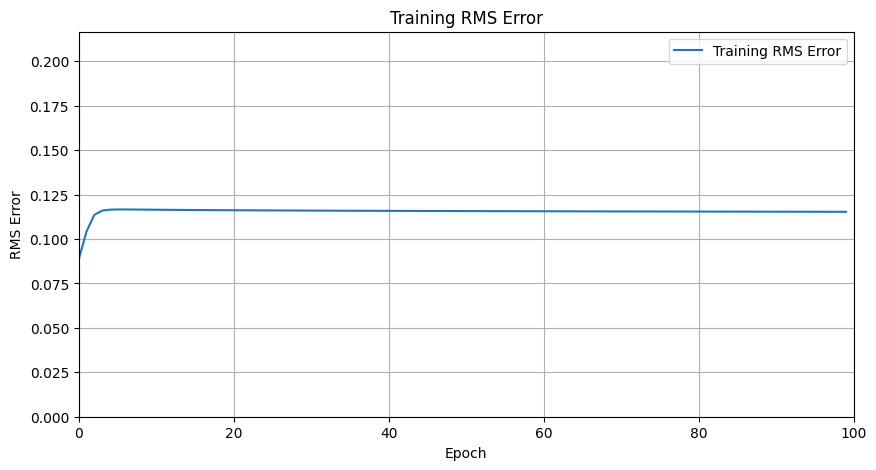

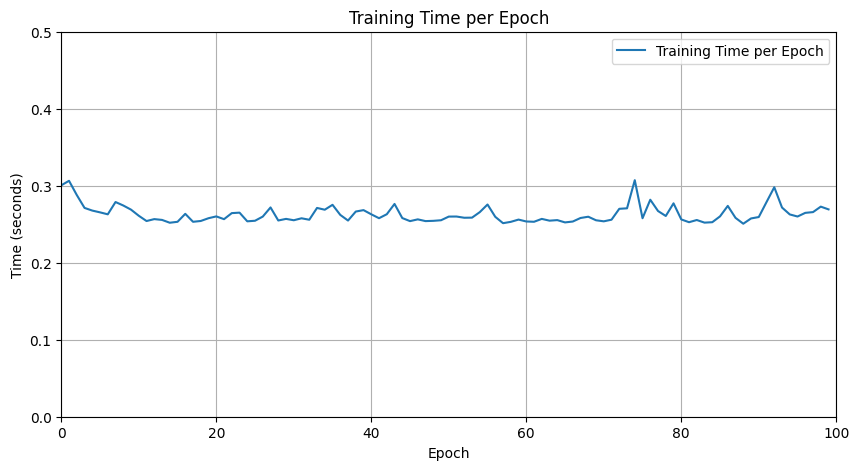

In [10]:
plot_results(
    results=train_errors,
    title="Training RMS Error",
    xlabel="Epoch",
    ylabel="RMS Error",
    xlim=(0, NUM_EPOCHS),
    ylim=(0, np.max(train_errors) + 0.1),
)

plot_results(
    results=times_per_epoch,
    title="Training Time per Epoch",
    xlabel="Epoch",
    ylabel="Time (seconds)",
    xlim=(0, NUM_EPOCHS),
    ylim=(0, 0.5),
)

### Test Evaluation

After training, the network is evaluated on the test set. The RMS error for each test sample is computed, and the time taken for each feedforward pass is measured. These metrics provide insight into the model's generalization and inference speed.

In [8]:
test_errors = []
times_per_feedforward = []

for inputs, targets in test_data:
    start_time = time.perf_counter()
    output_errors = nn.feedforward(inputs)

    rms_error = calculate_rms_error(np.array(output_errors), np.array(targets))
    time_elapsed = time.perf_counter() - start_time

    test_errors.append(rms_error)
    times_per_feedforward.append(time_elapsed)

mean_test_error = np.mean(test_errors)
mean_feedforward_time = np.mean(times_per_feedforward)

logger.info("Mean test RMS error: %.3f", mean_test_error)
logger.info("Mean number of feedforward calculations per second: %d", 1 / mean_feedforward_time)

[06-06-2025|00:29:14] Mean test RMS error: 0.010
[06-06-2025|00:29:15] Mean number of feedforward calculations per second: 10642


### Test Results Visualization

Plots are generated for the test RMS error and the number of feedforward calculations per second, summarizing the model's performance on unseen data and its inference throughput.

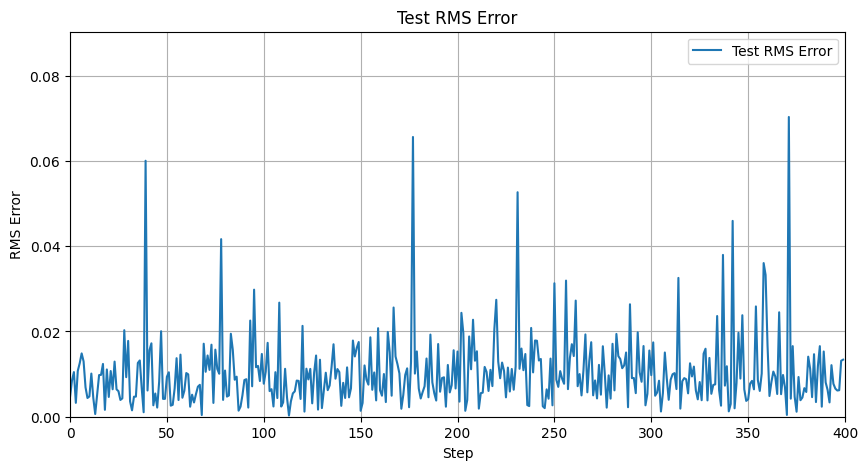

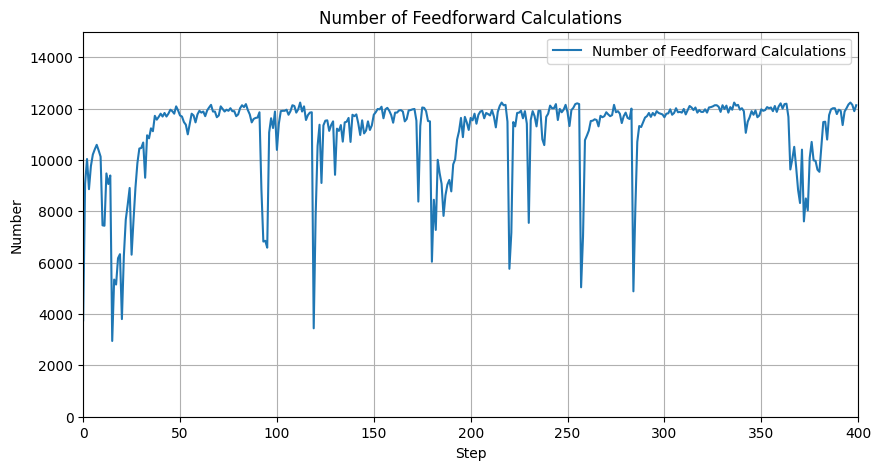

In [12]:
plot_results(
    results=test_errors,
    title="Test RMS Error",
    xlabel="Step",
    ylabel="RMS Error",
    xlim=(0, len(test_errors)),
    ylim=(0, np.max(test_errors) + 0.02),
)

plot_results(
    results=1 / np.array(times_per_feedforward),
    title="Number of Feedforward Calculations",
    xlabel="Step",
    ylabel="Number",
    xlim=(0, len(times_per_feedforward)),
    ylim=(0, 15000),
)